<a href="https://colab.research.google.com/github/praths007/tensorflow_certification/blob/master/coursera_practise/NLP_week3_LSTM_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.3.0'

In [102]:
import json
import numpy as np
import csv
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, GlobalAvgPool1D, Flatten

In [5]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-08-17 16:27:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   133MB/s    in 1.7s    

2020-08-17 16:27:29 (133 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [73]:
labels = []
sentences = []
corpus = []
with open("/tmp/training_cleaned.csv", 'r') as csvfile:
  reader = csv.reader(csvfile)
  header = 1
  for row in reader:
    if header != 1:
      # labels.append(np.int(row[0]))
      # sentences.append(row[5])
      corpus.append([np.int(row[0]), row[5]])
    else:
      header += 1

In [118]:
embedding_dims = 100
output_dims = 128
maxlen = 150
oov_token = "<oov>"

In [78]:
random.shuffle(corpus)
for item in corpus:
  sentences.append(item[1])
  labels.append(item[0])

In [79]:
train_size = int(len(corpus) * 0.8)
training_x = sentences[:train_size]
training_y = labels[:train_size]
testing_x = sentences[train_size:]
testing_y = labels[train_size:]

In [81]:
tokenizer = Tokenizer(vocab, oov_token=oov_token)
tokenizer.fit_on_texts(training_x)

In [82]:
train_seq = tokenizer.texts_to_sequences(training_x)
train_padded = pad_sequences(train_seq, maxlen=maxlen)

In [83]:
test_seq = tokenizer.texts_to_sequences(testing_x)
test_padded = pad_sequences(test_seq, maxlen=maxlen)

In [40]:
# label_tokenizer = Tokenizer()
# label_tokenizer.fit_on_texts(training_y)
# train_y = label_tokenizer.texts_to_sequences(training_y)
# test_y = label_tokenizer.texts_to_sequences(testing_y)

In [85]:
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
train_y = np.array(training_y)
test_y = np.array(testing_y)

In [86]:
train_padded.shape

(1279999, 150)

In [92]:
np.unique(train_y)

array([0, 4])

In [91]:
np.unique(test_y)

array([0, 4])

In [120]:
# GloVe Embedding

word_index = tokenizer.word_index
vocab_size = len(word_index)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dims));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-08-17 17:34:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   275MB/s    in 1.2s    

2020-08-17 17:34:37 (275 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [123]:
model = tf.keras.Sequential([
                             Embedding(vocab_size+1, embedding_dims, input_length=train_padded.shape[1], weights=[embeddings_matrix], trainable=False),
                             Bidirectional(LSTM(64, return_sequences=True)),
                             Bidirectional(LSTM(64)),
                             Flatten(),
                             Dense(128, activation='relu'),
                             Dense(1, activation='sigmoid')
])

In [124]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 100)          59519300  
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 150, 128)          84480     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               98816     
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 59,719,237
Trainable params: 199,937
Non-trainable params: 59,519,300
____________________________________

In [125]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_padded, train_y, validation_data=(test_padded, test_y), epochs = 10)

Epoch 1/10
  547/40000 [..............................] - ETA: 15:41 - loss: -1847.1002 - accuracy: 3.9991e-04

KeyboardInterrupt: ignored

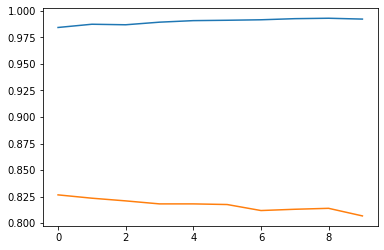

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])